<a href="https://colab.research.google.com/github/MaximusDecimusV/DSLearning/blob/master/Diff_in_diff_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Example of a model based approach to estimate the effects of a treatment using DiD

#### Key Assumptions:
* Parallel trends: pre-treatment, the trends in treatment and control must be parallel

* Linear relationships (same as regression). Model cannot predict non linear relationships in data. If you expect non-linearity, transform the data, or create features that represent the non linearity

#### Other notes:

* This is a base DiD, if there are confounding variables in the data, you can throw them into the model as a feature to control for confounders

In [169]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns
from matplotlib import pyplot as plt
import datetime as dt

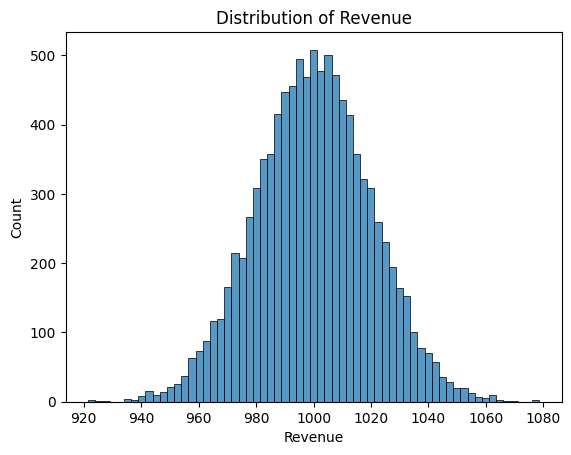

In [170]:
#Generate some fake revenue data fitting normal distributions
mu = 1000 #mean revenue per user
sigma = 20 #std. deviation
np.random.seed(42) #Ensures generated data is consistent across runs
rev = np.random.normal(mu, sigma, 10000)
sns.histplot(rev)
plt.title("Distribution of Revenue")
plt.xlabel("Revenue")
plt.ylabel("Count")
plt.show()


In [171]:
#Sampling some data from this distribution for baseline and post, treatment and control
np.random.seed(1)
baseline_control = np.random.choice(rev, 365)
np.random.seed(2)
baseline_treatment = np.random.choice(rev, 365)
np.random.seed(3)
post_treatment = np.random.choice(rev, 365)
np.random.seed(4)
post_control = np.random.choice(rev, 365)

In [172]:
#Apply some effect to post_treatment (an effect that DiD can detect)
mu, sigma = 1.1, 0.01 #10% effect with a low variance
np.random.seed(5)
effect = np.random.normal(mu, sigma, 365)

In [173]:
post_treatment = post_treatment * effect

In [174]:
#Make a time series out of it
dt_list = pd.date_range("2021-07-01", "2023-06-30").tolist()

#We have 730 dates, starting 2021-07-01, second half of data is post, so assume treatment started 2022-07-01
control = np.concatenate([baseline_control, post_control])
treatment = np.concatenate([baseline_treatment, post_treatment])

df = pd.DataFrame({'dates': np.concatenate([dt_list, dt_list]),
                   'revenue':np.concatenate([control, treatment]),
                   'is_treatment': np.concatenate([np.zeros(730), np.ones(730)])}) #First half of data is control

In [179]:
#Label post treatment and
df['is_post'] = (df['dates'] >= '2022-07-01').astype(int)
df['is_did'] = df['is_post'] * df['is_treatment']
df_month = df.groupby([df['dates'].dt.to_period('M'), 'is_treatment', 'is_post', 'is_did']).mean().reset_index()
df_month['month'] = df_month['dates'].astype('string')

<ipython-input-179-ba551f704c34>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_month = df.groupby([df['dates'].dt.to_period('M'), 'is_treatment', 'is_post', 'is_did']).mean().reset_index()


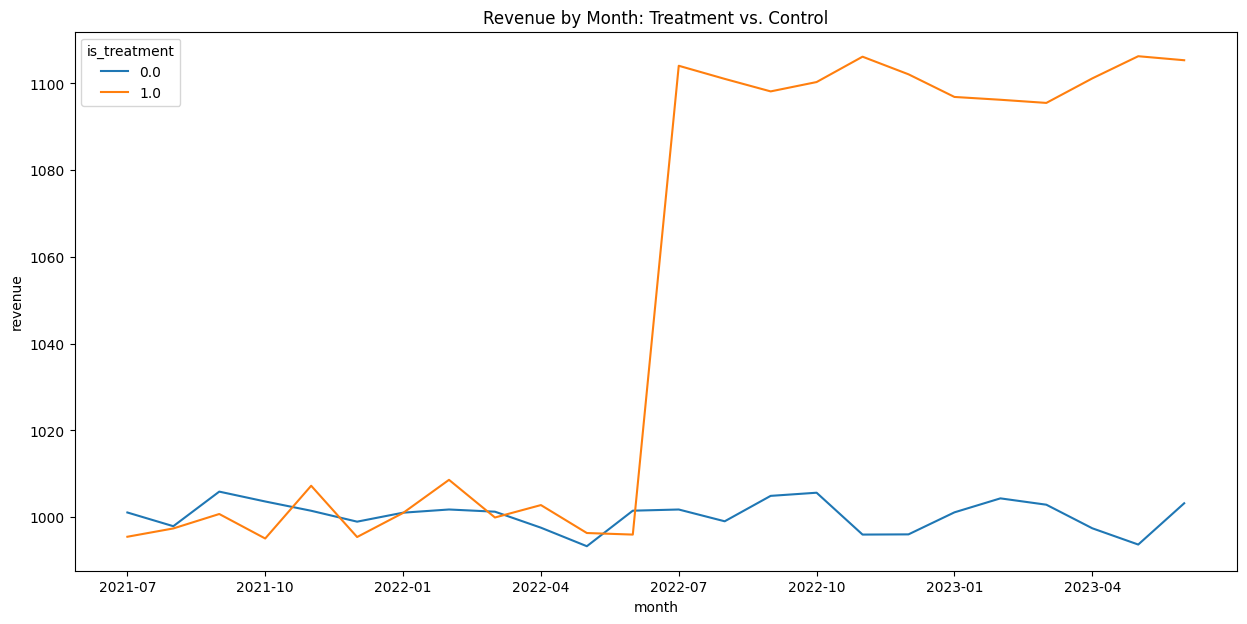

In [188]:
#Visual representation of monthly aggregates to validate parallel trends
plt.figure(figsize = (15,7))
ax = sns.lineplot(data = df_month, x = 'month', y = 'revenue', hue = 'is_treatment')
ax.set_xticks(range(24))
ax.set_xticks(ax.get_xticks()[::3])
plt.title("Revenue by Month: Treatment vs. Control")
plt.show()

In [190]:
#DiD Model
did_est = smf.ols(formula='revenue ~ is_treatment + is_post + is_did', data=df).fit()
did_est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     2122.
Date:                Mon, 24 Jul 2023   Prob (F-statistic):               0.00
Time:                        18:54:22   Log-Likelihood:                -6510.7
No. Observations:                1460   AIC:                         1.303e+04
Df Residuals:                    1456   BIC:                         1.305e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1000.4164      1.096    912.588      0.000     998.266    1002.567
is_treatment    -0.8554      1.550     -0.552      0.581      -3.897       2.186
is_post          0.0478      1.550      0.031      0.975      -2.993       3.089
is_did         101.5229      2.192     46.305      0.000      97.222     105.824
==============================================================================
Omnibus:                        2.846   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.241   Jarque-Bera (JB):                2.744
Skew:                           0.101   Prob(JB):                        0.254
Kurtosis:                       3.063   Cond. No.                         6.85
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [201]:
did_estimate = did_est.params['is_did']
pre_treatment_mean = df[df['is_post'] ==0]['revenue'].mean()
effect = did_estimate / pre_treatment_mean
print(f"Estimated Effect Size is: {effect: 0.1%}")

Estimated Effect Size is:  10.2%
